In [1]:
import dataclasses
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange

import jax.numpy as jnp
import jax.random as jr

from sklearn.model_selection import KFold

from fos import seminmf_full as seminmf

import warnings
warnings.filterwarnings("ignore")

## Combine all the per-mouse arrays into one file

In [2]:
# DATA_DIREC = "/scratch/groups/swl1/serotonin/npz_4"

# N = len(os.listdir(DATA_DIREC))
# height = 89
# width = 95
# depth = 80
# intensity_3d = np.zeros((N, height, width, depth), dtype=np.float32)
# counts_3d = np.zeros((N, height, width, depth), dtype=np.int16)
# inds = -1 * np.ones(N)

# for i, fname in enumerate(os.listdir(DATA_DIREC)):
#     # print(fname)
#     ind = int(fname[:3])
#     inds[i] = ind

#     npz = np.load(os.path.join(DATA_DIREC, fname))
#     coords = npz["coords"]
#     x, y, z = coords.T
#     intensity_3d[i][x, y, z] = npz["log_vs"]
#     counts_3d[i][x, y, z] = npz["Ns"]
    
# np.savez(os.path.join(DATA_DIREC, f"downsampled_data_4.npz"),
#          intensity=intensity_3d, counts=counts_3d, mouse_inds=inds)

## Load the combined data

In [3]:
!ls -lh /scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz

-rw-rw----+ 1 swl1 swl1 655M Nov  1 17:44 /scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz


In [4]:
DATA_DIREC = "/scratch/groups/swl1/serotonin/npz_4"
data = np.load(os.path.join(DATA_DIREC, f"downsampled_data_4.npz"))
intensity_3d = data["intensity"][:-1]
counts_3d = data["counts"][:-1]
mouse_inds = data["mouse_inds"]
assert intensity_3d.shape[0] == 168
assert counts_3d.shape[0] == 168

In [5]:
DRUG_DATA_DIREC = "/scratch/groups/swl1/serotonin"
drugs = np.load(os.path.join(DRUG_DATA_DIREC, "drug_ids.npy"))

### Only work with live voxels

In [6]:
alive_voxels = jnp.sum(counts_3d, axis=0) > 0
print(alive_voxels.sum(), "/", np.prod(intensity_3d.shape[1:]), "voxels are 'alive'")


384008 / 676400 voxels are 'alive'


In [7]:
intensity = intensity_3d[:, alive_voxels]
counts = counts_3d[:, alive_voxels]
intensity[counts == 0] = 0.0

(<Axes: >, <matplotlib.image.AxesImage at 0x7f95dc5e5b80>)

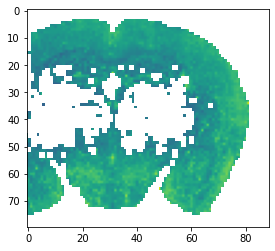

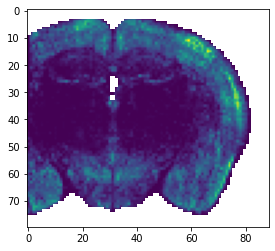

In [8]:
def plot_coronal(flat_array, y_idx, ax=None):
    arr = jnp.nan * jnp.zeros(alive_voxels.shape)
    arr = arr.at[alive_voxels].set(flat_array)

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    im = ax.imshow(arr[:, y_idx, :].T)
    return ax, im

vis_intensity = jnp.where(counts == 0, jnp.nan, intensity)

plot_coronal(vis_intensity[100], 50)
plot_coronal(counts[100], 50)

### Make random masks

Mask off hyperrectangles for each mouse.

In [9]:
# def make_masks(key, size, num_rect_per_mouse=3):
key = jr.PRNGKey(0)
size = 10
num_rect_per_mouse = 3

M, H, W, D = counts_3d.shape
masks_3d = jnp.ones_like(counts_3d, dtype=bool)

for m in trange(M):
    for i in range(num_rect_per_mouse):
        k1, k2, k3, key = jr.split(key, 4)
        x,y,z = jr.randint(k1, (3,), minval=jnp.zeros(3), maxval=jnp.array([H, W, D]))
        masks_3d = masks_3d.at[m, x:x+size, y:y+size, z:z+size].set(False)

masks = masks_3d[:, alive_voxels]


  0%|          | 0/168 [00:00<?, ?it/s]

(<Axes: >, <matplotlib.image.AxesImage at 0x7f95dc1d8430>)

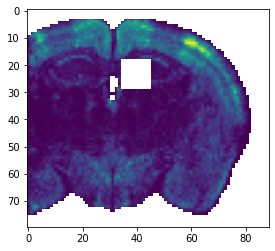

In [10]:
plot_coronal(jnp.where(masks[0], counts[0], jnp.nan), 50)

## Implement a simple log-linear Poisson model

## Select hyperparameters by cross validation

In [ ]:
mean_func = "softplus"
elastic_net_frac = 1.0
num_iters = 500
num_coord_ascent_iters = 1

# Compute the SVD initialization once
max_num_factors = 24
full_initial_params = seminmf.initialize_nnsvd(counts, intensity, max_num_factors, mean_func, drugs=None)

# Fit the model
all_sparsity_penalties = jnp.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
all_num_factors = jnp.arange(2, max_num_factors+1, 2)
all_heldout_loglikes = jnp.zeros((len(all_sparsity_penalties), len(all_num_factors)))

for i, sparsity_penalty in enumerate(all_sparsity_penalties):
    for j, num_factors in enumerate(all_num_factors):
        print("fitting model with", sparsity_penalty, "sparsity and ", num_factors, "factors")
        initial_params = dataclasses.replace(
            full_initial_params,
            factors=full_initial_params.factors[:num_factors],
            count_loadings=full_initial_params.count_loadings[:, :num_factors],
            intensity_loadings=full_initial_params.intensity_loadings[:, :num_factors],
        )

        params, losses, heldout_loglikes = \
            seminmf.fit_poisson_seminmf(counts,
                                intensity,
                                initial_params,
                                mask=masks,
                                mean_func=mean_func,
                                sparsity_penalty=sparsity_penalty,
                                elastic_net_frac=elastic_net_frac,
                                num_iters=num_iters,
                                num_coord_ascent_iters=num_coord_ascent_iters,
                                tolerance=1e-5
                                )

        all_heldout_loglikes = all_heldout_loglikes.at[i, j].set(heldout_loglikes[-1])


fitting model with 1e-04 sparsity and  2 factors


fitting model with 1e-04 sparsity and  4 factors


fitting model with 1e-04 sparsity and  6 factors


fitting model with 1e-04 sparsity and  8 factors


fitting model with 1e-04 sparsity and  10 factors


fitting model with 1e-04 sparsity and  12 factors


In [ ]:
plt.plot(all_num_factors, all_heldout_loglikes)
plt.xlabel("num factors")
plt.ylabel("heldout log like")

In [ ]:
best_num_factors = all_num_factors[jnp.argmax(all_heldout_loglikes)]
print("Optimal number of factors:", best_num_factors)


## Fit model with a chosen number of factors on all data

In [ ]:
initial_params = initialize_nnsvd(counts, intensity, best_num_factors, mean_func, drugs=None)

In [ ]:
sparsity_penalty = 1e-2
elastic_net_frac = 1.0
num_iters = 200
num_coord_ascent_iters = 1

print("fitting model with", best_num_factors, "factors")
params, losses, heldout_loglikes = \
    fit_poisson_seminmf(counts,
                        intensity,
                        initial_params,
                        mask=None,
                        mean_func=mean_func,
                        sparsity_penalty=sparsity_penalty,
                        elastic_net_frac=elastic_net_frac,
                        num_iters=num_iters,
                        num_coord_ascent_iters=num_coord_ascent_iters,
                        tolerance=1e-5
                        )

In [ ]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(30, 15), sharey=True, sharex=True)
for k, ax in enumerate(axs.ravel()):
    if k < best_num_factors:
        plot_coronal(params.factors[k], y_idx=50, ax=ax)
        ax.set_title("factor {}".format(k))
    else:
        ax.set_visible(False)
        
plt.tight_layout()

In [ ]:
perm = jnp.argsort(drugs)
bounds = jnp.cumsum(jnp.bincount(drugs)[1:-1])

loadings = params.count_loadings
vmax = abs(loadings).max()

plt.imshow(loadings[perm], vmin=-vmax, vmax=vmax, cmap="RdBu", aspect="auto", interpolation="none")
for bound in bounds:
    plt.axhline(bound, color='k')
_ = plt.xticks(np.arange(best_num_factors))

plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by drug group)")
plt.colorbar()

plt.figure()
plt.imshow(loadings, aspect="auto", cmap="RdBu", vmin=-vmax, vmax=vmax, interpolation="none")
plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by index/batch)")
plt.colorbar()

In [ ]:
perm = jnp.argsort(drugs)
bounds = jnp.cumsum(jnp.bincount(drugs)[1:-1])

loadings = params.intensity_loadings
vmax = abs(loadings).max()

plt.imshow(loadings[perm], vmin=-vmax, vmax=vmax, cmap="RdBu", aspect="auto", interpolation="none")
for bound in bounds:
    plt.axhline(bound, color='k')
_ = plt.xticks(np.arange(best_num_factors))

plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("intensity loadings (sorted by drug group)")
plt.colorbar()

plt.figure()
plt.imshow(loadings, aspect="auto", cmap="RdBu", vmin=-vmax, vmax=vmax, interpolation="none")
plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("intensity loadings (sorted by index/batch)")
plt.colorbar()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# normalize weights and factors
def normalize_weights(weights):
    U = weights
    U = U - U.mean()
    U /= U.std()
    return(U)

def downstream_task(W, drugs, **kwargs):
    """
    kwargs
    ------
    cv: pass in the same CV splitter for both the grid search and the confusion matrix
    """
#     W_norm = normalize_weights(W)
    W_norm = W
    parameters = {"C":10 ** np.linspace(-15,15,num=31)}
    lr = LogisticRegression()
    gridsearch = GridSearchCV(lr, parameters, **kwargs)
    gridsearch.fit(W_norm, drugs)
    drug_clf_acc = gridsearch.best_score_
    classifier = gridsearch.best_estimator_
    drugs_pred = cross_val_predict(classifier, W_norm, y=drugs, **kwargs)
    confusion_mat = confusion_matrix(drugs, drugs_pred)
    return(classifier, drug_clf_acc, confusion_mat)

In [ ]:
features = jnp.hstack([normalize_weights(params.count_loadings),
                       normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)

print(acc)
plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("count + intensity loadings (acc={:.2f})".format(acc))
plt.colorbar()

In [ ]:
features = jnp.hstack([normalize_weights(params.count_loadings),
#                        normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)

print(acc)
plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("count loadings (acc={:.2f})".format(acc))
plt.colorbar()

In [ ]:
features = jnp.hstack([normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)

print(acc)
plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("intensity loadings (acc={:.2f})".format(acc))
plt.colorbar()

In [ ]:
ax, im = plot_coronal(params.intensity_variance, 50)
plt.colorbar(im)
ax.set_title("estimated intensity variance")

In [ ]:
ax, im = plot_coronal((counts.mean(axis=0)) / params.intensity_variance, 50)
# im.set_clim(0, 1)
plt.colorbar(im)
ax.set_title("average weight per voxel")

## Sort factors by decoding importance

### Single feature decoding

In [ ]:
from fastprogress.fastprogress import master_bar, progress_bar

accs = -jnp.inf * jnp.ones(best_num_factors)
for j in progress_bar(range(best_num_factors)):
    features = params.count_loadings[:,j:j+1]
    features = normalize_weights(features)
    cv = KFold(shuffle=True, random_state=0)
    _, acc, _ = downstream_task(features, drugs, cv=cv)
    accs = accs.at[j].set(acc)

jnp.argsort(accs)[::-1]

### Greedy Forward
Use a greedy forward procedure where we build up the model one feature at a time, adding the feature that most improves the classification accuracy. Intuitively, we expect this approach to yield an ordering that is similar to the norm of the weights of the full decoder, but that's not strictly guaranteed.

In [ ]:
from fastprogress.fastprogress import master_bar, progress_bar

indices = jnp.array([], dtype=int)

mb = master_bar(range(best_num_factors))        
for i in mb:
    accs = -jnp.inf * jnp.ones(best_num_factors)
    for j in progress_bar(range(best_num_factors), parent=mb):
        if j not in indices:
            features = jnp.column_stack([params.count_loadings[:,indices],
                                         params.count_loadings[:,j]])
            features = normalize_weights(features)
            cv = KFold(shuffle=True, random_state=0)
            _, acc, _ = downstream_task(features, drugs, cv=cv)
            accs = accs.at[j].set(acc)
            
    best_j = jnp.argmax(accs)
    indices = jnp.insert(indices, 0, best_j)
#     indices = jnp.concatenate([indices, jnp.array([best_j])])
    

In [ ]:
indices[::-1]

### Leave one out accuracy

How much does performance drop when we leave out one feature?

In [ ]:
loo_acc = []


for k in progress_bar(range(best_num_factors)):
    
    features = jnp.hstack([params.count_loadings[:,:k],
                           params.count_loadings[:,k+1:]])
    features = normalize_weights(features)
    cv = KFold(shuffle=True, random_state=0)
    _, acc, _ = downstream_task(features, drugs, cv=cv)
    loo_acc.append(acc)
    
loo_acc = jnp.array(loo_acc)

In [ ]:
jnp.argsort(loo_acc)

In [ ]:
features = normalize_weights(params.count_loadings)
cv = KFold(shuffle=True, random_state=0)
_, full_acc, _ = downstream_task(features, drugs, cv=cv)

In [ ]:
plt.bar(jnp.arange(best_num_factors), full_acc - loo_acc)

### Look at normalized features

In [ ]:
perm = jnp.argsort(drugs)
bounds = jnp.cumsum(jnp.bincount(drugs)[1:-1])

loadings = params.count_loadings
loadings -= loadings.mean(axis=0)
loadings /= loadings.std(axis=0)
vmax = abs(loadings).max()

plt.imshow(loadings[perm], vmin=-vmax, vmax=vmax, cmap="RdBu", aspect="auto", interpolation="none")
for bound in bounds:
    plt.axhline(bound, color='k')
_ = plt.xticks(np.arange(best_num_factors))

plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by drug group)")
plt.colorbar()

plt.figure()
plt.imshow(loadings, aspect="auto", cmap="RdBu", vmin=-vmax, vmax=vmax, interpolation="none")
plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by index/batch)")
plt.colorbar()

## Save factors to tiff stack

In [ ]:
# im = ax.imshow(arr[:, y_idx, :].T)

In [ ]:
# def save_factor(factor, filename):
#     arr = jnp.zeros(alive_voxels.shape)
#     arr = arr.at[alive_voxels].set(factor)
    
#     for 
#     imsave(filename, arr)
    
# for k, factor in enumerate(params.factors):
#     save_factor(params.factors[2], os.path.join("2023_11_01_outputs", "factor{}.tif".format(k)))

### Experimenting with tifffile

In [ ]:
!pip install tifffile

In [ ]:
from tifffile import imsave

In [ ]:
!mkdir 2023_11_01_outputs

In [ ]:
def save_factor(factor, filename):
    arr = jnp.zeros(alive_voxels.shape)
    arr = arr.at[alive_voxels].set(factor)
    arr = jnp.transpose(arr, (1, 2, 0))
    arr /= arr.max()
    imsave(filename, arr)
    
for k, factor in enumerate(params.factors):
    save_factor(factor, os.path.join("2023_11_01_outputs", "factor{}.tif".format(k)))

In [ ]:
!ls -lh 2023_11_01_outputs/

In [ ]:
!pwd